# Generalized Tophat shift approximations


Accounting for cross terms, higher order shift approximations can be generalized up to shift in order $k$ by combining expansions:\\


\begin{equation}
	\sum_{B=0}^{\lfloor{k/2}\rfloor}
	\sum_{A=0}^{k-2B}
\lbrace
	[
		\frac{1}{B!}
		(-\frac{a^2}{w^2})^B
	]
	[
		\frac{1}{A!}
		(-\frac{2ax}{w^2})^A
	]
\left[
{n \choose M}
(\frac{2ae^{i\Psi}}{w\sqrt{n}})^M
\right]
u_{n-M,m}		
\rbrace
\end{equation}

where

\begin{equation}
	M \equiv k-(A+2B)
\end{equation}

In [1]:
import PauLisa as pl, PL_Plot as plplt,plback as plb, Tophat_integration_AW as th, numpy as np, matplotlib.pyplot as plt, cmath as cm

from numpy import pi as pi
from numpy import angle
#from numpy import sqrt as sqrt
from scipy.special import erf as erf
import mpmath as mp
import scipy.io

from math import pi, log, exp, sin, cos, atan, e, radians, degrees
from scipy.special import gamma as gamma
from scipy.special import erf as erf
from scipy.special import comb

from math import factorial as fac
import cmath
from cmath import sqrt as sqrt
import numpy as np

from time import process_time

inf=np.inf

import pandas as pd
from pprint import pprint

import queue


## Tophat coeffients from AW

In [3]:
mat = scipy.io.loadmat('Top_hat_for_paul.mat')
# mat = scipy.io.loadmat('paul_coef_file.mat')
# for x in mat:
#   print(x)
# coef=mat['coeftopUnitInt'].ravel()
# print(mat['readmepaul'])
coef=mat['coeftop'].ravel()

def N_f(A):
    
    res = np.floor((np.sqrt(8*A+1)-1)/2)
    
    #res = (np.sqrt(9+8*A)-3)/2
    return(res)

def m(N,A):
    res = (N+1)*(N+2)/2 - (A+1)
    return(res)

#def n(N,A):
#    m= (N+1)*(N+2)/2 - (A+1)
#    res = N-m
#    return(res)
def n(N,A):
    res = A - (N*(N+1)/2)
    return(res)

NumberModes = int(len(coef))
listModesN = [None] * NumberModes
listModesM = [None] * NumberModes
listModesC = [None] * NumberModes

#area = pi*1e-3**2
area = 1
#for i in range(len(coef)):
#    A=i
#    N= N_f(A)
#
#    if (m(N,A)%2 == 0) & (n(N,A)%2 == 0):
#        print(coef[A], '\t\t\t' , m(N,A), ',' , n(N,A))

for i in range(NumberModes):
    A=i
    N= N_f(A)
    listModesN[i] = int(m(N,A))
    listModesM[i] = int(n(N,A))
    listModesC[i] = coef[i]/sqrt(area)
    
    

In [52]:
modes_0 = plb.modes((0,0,1))
modes_2 = plb.modes((2,0,1),(0,0,1))
modes_3 = plb.modes( (0,0,2),(1,0,.5),(2,0,2),(3,0,3),(4,0,1),(5,0,1),(7,0,1),(0,18,1))
modes = pl.create_modes(listModesM,listModesN,listModesC,NumberModes)

N=18 # mode order
modes_N= pl.create_modes_orderN(listModesM,listModesN,listModesC,NumberModes,N)

plane = pl.Plane(-2e-3,2e-3,300,-2e-3,2e-3,300)

## Expansion function

In [148]:
# Apply general mode scatter formulas for x-dependence (uni-directional offset coord.), RETURN new modes(on-axis)
# Up to approximation order k
def shift(z,params,a,alpha,modes,k):
    
    #get params
    K = params.getK()
    w0 = params.getW0()
    zr = params.getZr()
    w_z = pl.w(z,params)
    gouy = pl.gouy_phase(z,params) 
    
    #get shape to iterate through modes
    rows = len(modes)
    cols = len(modes[0])
    
    number_modes = rows*cols
    
    #build new modes (up to 2 orders larger for quad. dep.)
    new_modes = [[0 for m in range(cols+k+1)] for n in range(rows+k+1)]
    
    for i in range(rows):
        for j in range(cols):
            new_modes[i][j] = modes[i][j]
    
    pl.show_modes(new_modes)
    
    A_sub = 0
    M_sub = 0
    
    # iterate all modes
    for n in range(rows):
        for m in range(cols):            
            #ignore zero coeff.
            if (modes[n][m]!=0):
                c_nm = modes[n][m]
                for B in range( int( np.floor(k) +1 ) ): #+1 for inclusive
                    for A in range( int((k-2*B) +1)):
                        sum_B = (
                          (  (1/fac(B))*
                            (-a**2/w_z**2) )**B
                        )
                        
                        sum_A = (
                           ( (1/fac(A))*
                            (-2*a/w_z**2) )**A
                        )
                        
                        M = (k- (A+2*B) )
                        
                        print('B:',B,'A:',A,'M:',M,'k',k,'n',n)
                        
                        if(n>0):
                            sum_M = (
                                (comb(n,M)
                                * (2*a*e**( (1j)*gouy))/(w_z*sqrt(n))
                                )**M
                            )
                        
                        else:
                            sum_M = 1
                        #print(A,M)    
                        #overall coupling result
                        
                        coupling = (sum_B*sum_A*sum_M)
                        print(a,w_z,sum_A,A,'w',w_z,(
                            (1/fac(A))*
                            (-2*a/w_z**2)**A
                        ))
                        
                        #print(B,A,M,n,coupling*c_nm)
                        #no coupling into other modes
                        if (A ==0 and M==0):
                            new_modes[n][m]+=c_nm*coupling
                            print('n,m: ez',n,m,c_nm*coupling)  
                            
                        # couple into modes (n-M, and X**A)   
                        # n-M determines start, need n+1,n-1 for each x
                        
                        if (A==0 and B==0 and (n-M)>=0):
                            new_modes[n-M][m]+=c_nm*coupling
                            print('M into',n-M,B,A,M,'n,m:',n,m,c_nm*coupling)
                        else:
                            M_sub = M
                            A_sub = A
                            n_start = n-M
                            #print(n_start,'nst')
                            
                            #print('a',A)
                            
                            q = queue.Queue()
                            #queue with n and coeff.
                            q.put(n_start)
                            temp = queue.Queue()
                            
                            while(A_sub!=0):
                                while(not q.empty()):
                                    #for each (n) in the q, +/- 1 append with a coupling
                                    f = q.get()
                                    
                                    
                                    #n+1 (working coeff. * coupling * scatter coupling)
                                    total_coup = c_nm*coupling*x_plus_1(w0,z,zr,f)
                                    new_modes[int(f+1)][m] += total_coup
                                    #print('plus',int(f+1),'A_sub:',A_sub,'n,m:',n,m,total_coup)
                                    #print('f+1',f+1,rows)
                                    if(f+1<=rows):
                                        temp.put(f+1)
                                    
                                    #n-1
                                    if(f-1>=0):
                                        total_coup = c_nm*coupling*x_minus_1(w0,z,zr,f)
                                        new_modes[f-1][m] += total_coup
                                        print('minus',f-1,'n:',n,total_coup,x_minus_1(w0,z,zr,f),coupling)
                                        temp.put(f-1)

                                if(q.empty()):
                                    
                                    A_sub-=1
                                    #print('As',A_sub)
                                    #q emptied, decrement A, refill q with temp
                                    while(not temp.empty()):
                                        #print('i')
                                        q.put(temp.get())
                                        if(not q.empty()):
                                            print('y',A,A_sub)

    return(new_modes)

#x dep
def x_plus_1(w0,z,zr,n):    
    factor = (w0/2)*( ( 1-(1j)*(z/zr) )*np.sqrt(n+1))
    return(factor)

#x dep
def x_minus_1(w0,z,zr,n):
    factor = (w0/2)*( np.sqrt(n)*(1+(1j)*(z/zr)) )
    return(factor)

In [158]:
z=0
params = pl.Params(1064e-9,0.00023067,0)
plane=pl.Plane(-2e-3,2e-3,200,-2e-3,2e-3,200)

a = 10e-6
alpha = 0
k = 2
sc_modes = shift(z,params,a,alpha,modes,k)

n\m [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
0   [(0.0005782135489454484+0j), 0j, (0.00040885861556282983+0j), 0j, (0.0003540803162272261+0j), 0j, (0.000323212982065895+0j), 0j, (0.0003022158047268879+0j), 0j, (0.0002860296460147838+0j), 0j, (0.00027094445327376657+0j), 0j, (0.0002512919866755189+0j), 0j, (0.00021738092777959212+0j), 0j, (0.00015798140510481738+0j), 0j, (7.192607227785025e-05+0j), 0j, (-1.6391805321537432e-05+0j), 0j, (-6.0842902421992335e-05+0j), 0j, (-3.51766787113729e-05+0j), 0j, (2.2328640904269448e-05+0j), 0j, (3.720198862288632e-05+0j), 0j, (-4.422997044297867e-06+0j), 0j, (-3.069071621773588e-05+0j), 0, 0, 0]
1   [0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0, 0, 0, 0]
2   [(0.00040885861556282983+0j), 0j, (0.00028910536757333815+0j), 0j, (0.00025035969936384935+0j), 0j, 

1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
y 1 0
B: 0 A: 2 M: 0 k 2 n 0
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
y 2 1
minus 0 n: 0 (9.096177925834675e-05+0j) (0.000115335+0j) 35321.20712930764
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 0
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 0 28 (-4.196430724304569e-08+0j)
B: 0 A: 0 M: 2 k 2 n 0
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
B: 0 A: 1 M: 1 k 2 n 0
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
y 1 0
B: 0 A: 2 M: 0 k 2 n 0
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
y 2 1
minus 0 n: 0 (0.00015155239817751142+0j) (0.000115335+0j) 35321.20712930764
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 0
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 0 30 (-6.991718337521313e-08+0j)
B: 0 A: 0 M: 2 k 2 n 0
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
B: 0 A: 1 M: 1 k 2 n 0
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
y 1 0
B: 0 A: 2 M: 0 k 2 n 0


B: 0 A: 2 M: 0 k 2 n 2
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 1 n: 2 (-0.00025319101136970547+0j) (0.00016310832121630092+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 2 n: 2 (-0.00031009439265749627+0j) (0.00019976607989095646+0j) (35321.20712930764+0j)
minus 0 n: 2 (-0.000179033081074999+0j) (0.000115335+0j) (35321.20712930764+0j)
y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 2
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 2 22 (8.259512162314006e-08-0j)
B: 0 A: 0 M: 2 k 2 n 2
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 0 0 0 2 n,m: 2 24 (-9.534639305345662e-08+0j)
B: 0 A: 1 M: 1 k 2 n 2
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
minus 0 n: 2 (1.348401621795542e-07+0j) (0.000115335+0j) (-46.08946238555687+0j)
y 1 0
y 1 0
B: 0 A: 2 M: 0 k 2 n 2
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 1 n: 2 (-0.0001461396824246263+0j) (0.00016310832121630092+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 2

B: 0 A: 0 M: 2 k 2 n 4
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 2 0 0 2 n,m: 4 26 (1.5964702114837877e-06+0j)
B: 0 A: 1 M: 1 k 2 n 4
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
minus 2 n: 4 (-3.072408354511278e-07+0j) (0.00019976607989095646+0j) (-65.18034278813914+0j)
y 1 0
y 1 0
B: 0 A: 2 M: 0 k 2 n 4
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 3 n: 4 (0.0001922503783042378+0j) (0.00023067+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 4 n: 4 (0.00021494245729416323+0j) (0.0002578969001849383+0j) (35321.20712930764+0j)
minus 2 n: 4 (0.0001664937114986386+0j) (0.00019976607989095646+0j) (35321.20712930764+0j)
y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 4
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 4 26 (-4.4346394763438536e-08+0j)
B: 0 A: 0 M: 2 k 2 n 4
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 2 0 0 2 n,m: 4 28 (-1.8936876063623756e-07+0j)
B: 0 A: 1 M: 1 k 2 n 4
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -3

y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 6
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 6 20 (3.9405575737813676e-08-0j)
B: 0 A: 0 M: 2 k 2 n 6
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 4 0 0 2 n,m: 6 22 (3.7329470934100507e-06+0j)
B: 0 A: 1 M: 1 k 2 n 6
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
minus 4 n: 6 (-2.7261591053787063e-07+0j) (0.0002578969001849383+0j) (-79.82929054531918+0j)
y 1 0
y 1 0
B: 0 A: 2 M: 0 k 2 n 6
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 5 n: 6 (0.0001321341543570208+0j) (0.00028251189948389784+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 6 n: 6 (0.00014272119863187517+0j) (0.0003051477274616346+0j) (35321.20712930764+0j)
minus 4 n: 6 (0.00012062142826368306+0j) (0.0002578969001849383+0j) (35321.20712930764+0j)
y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 6
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 6 22 (-2.4886313956067008e-08+0j)
B: 0 A: 0 M: 2 k 2 n 6
1e-05 0.00023067 1.0 0 w 0.00023067 

B: 0 A: 2 M: 0 k 2 n 10
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 9 n: 10 (0.001752443763555919+0j) (0.00036472129393552005+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 10 n: 10 (0.0018379785251380488+0j) (0.00038252292019564006+0j) (35321.20712930764+0j)
minus 8 n: 10 (0.0016625141292582841+0j) (0.00034600500000000003+0j) (35321.20712930764+0j)
y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 10
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 10 6 (-2.55661422797339e-07+0j)
B: 0 A: 0 M: 2 k 2 n 10
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 8 0 0 2 n,m: 10 8 (0.00014486069782119524+0j)
B: 0 A: 1 M: 1 k 2 n 10
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
minus 8 n: 10 (-3.3932573967138372e-06+0j) (0.00034600500000000003+0j) (-103.0591709405248+0j)
y 1 0
y 1 0
B: 0 A: 2 M: 0 k 2 n 10
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 9 n: 10 (0.001225870072944696+0j) (0.00036472129393552005+0j) (35321.2071293

1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 10 0 0 2 n,m: 12 4 (0.00038933922535493187+0j)
B: 0 A: 1 M: 1 k 2 n 12
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
minus 10 n: 12 (-6.161387247399432e-06+0j) (0.00038252292019564006+0j) (-112.89566536381268+0j)
y 1 0
y 1 0
B: 0 A: 2 M: 0 k 2 n 12
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 11 n: 12 (0.0020134045968566434+0j) (0.00039953215978191293+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 12 n: 12 (0.0020956179462226455+0j) (0.00041584625635563923+0j) (35321.20712930764+0j)
minus 10 n: 12 (0.0019276881399117722+0j) (0.00038252292019564006+0j) (35321.20712930764+0j)
y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 12
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 12 4 (-2.6813996236565553e-07+0j)
B: 0 A: 0 M: 2 k 2 n 12
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 10 0 0 2 n,m: 12 6 (0.00026578707850623046+0j)
B: 0 A: 1 M: 1 k 2 n 12
1e-05 0.00023067 -375.8787417735014 1 w 0.0002306

y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 14
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 14 2 (-2.983586069252875e-07+0j)
B: 0 A: 0 M: 2 k 2 n 14
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 12 0 0 2 n,m: 14 4 (0.0004571726790266394+0j)
B: 0 A: 1 M: 1 k 2 n 14
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
minus 12 n: 14 (-5.213522091148021e-06+0j) (0.00041584625635563923+0j) (-121.94125553284924+0j)
y 1 0
y 1 0
B: 0 A: 2 M: 0 k 2 n 14
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 13 n: 14 (0.0015671423066417245+0j) (0.0004315440547035725+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 14 n: 14 (0.0016221463986026833+0j) (0.00044669053423483245+0j) (35321.20712930764+0j)
minus 12 n: 14 (0.0015101361130815444+0j) (0.00041584625635563923+0j) (35321.20712930764+0j)
y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 14
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 14 4 (-1.9322598437305124e-07+0j)
B: 0 A: 0 M: 2 k 2 n 14
1e-05 0.00023067

1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 15 n: 16 (0.0007577197668733819+0j) (0.00046134+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 16 n: 16 (0.0007810396583593358+0j) (0.0004755383873306129+0j) (35321.20712930764+0j)
minus 14 n: 16 (0.0007336590095481936+0j) (0.00044669053423483245+0j) (35321.20712930764+0j)
y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 16
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 16 4 (-8.739160931234151e-08+0j)
B: 0 A: 0 M: 2 k 2 n 16
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 14 0 0 2 n,m: 16 6 (-6.699212442599719e-05+0j)
B: 0 A: 1 M: 1 k 2 n 16
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
minus 14 n: 16 (5.76576404953205e-07+0j) (0.00044669053423483245+0j) (-130.36068557627829+0j)
y 1 0
y 1 0
B: 0 A: 2 M: 0 k 2 n 16
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 15 n: 16 (-0.000161346715668842+0j) (0.00046134+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 16 n: 16 (-0.000

y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 18
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 18 6 (6.857002315045981e-08-0j)
B: 0 A: 0 M: 2 k 2 n 18
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 16 0 0 2 n,m: 18 8 (-0.00019672984462564783+0j)
B: 0 A: 1 M: 1 k 2 n 18
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
minus 16 n: 18 (1.3230937258276154e-06+0j) (0.0004755383873306129+0j) (-138.26838715667063+0j)
y 1 0
y 1 0
B: 0 A: 2 M: 0 k 2 n 18
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 17 n: 18 (-0.0003477883597512151+0j) (0.0004893249636489027+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 18 n: 18 (-0.00035731857248666715+0j) (0.0005027336096532636+0j) (35321.20712930764+0j)
minus 16 n: 18 (-0.0003379895325494145+0j) (0.0004755383873306129+0j) (35321.20712930764+0j)
y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 18
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 18 8 (3.781811699839442e-08-0j)
B: 0 A: 0 M: 2 k 2 n 18
1e-05 0.00023067

y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 20
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 20 12 (4.429996658523584e-09-0j)
B: 0 A: 0 M: 2 k 2 n 20
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 18 0 0 2 n,m: 20 14 (-0.00021708064978593312+0j)
B: 0 A: 1 M: 1 k 2 n 20
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
minus 18 n: 20 (1.1722107754576114e-06+0j) (0.0005027336096532636+0j) (-145.74767727101727+0j)
y 1 0
y 1 0
B: 0 A: 2 M: 0 k 2 n 20
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 19 n: 20 (-0.0002914592223767593+0j) (0.0005157938003698766+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 20 n: 20 (-0.0002986568301979522+0j) (0.0005285313677777318+0j) (35321.20712930764+0j)
minus 18 n: 20 (-0.0002840793100404216+0j) (0.0005027336096532636+0j) (35321.20712930764+0j)
y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 20
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 20 14 (3.0066571992511524e-08-0j)
B: 0 A: 0 M: 2 k 2 n 22
1e-05 0.00023067 1.

B: 0 A: 0 M: 2 k 2 n 24
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 22 0 0 2 n,m: 24 8 (-5.922430251687541e-05+0j)
B: 0 A: 1 M: 1 k 2 n 24
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
minus 22 n: 24 (2.1919597520487817e-07+0j) (0.0005531272287412725+0j) (-159.65858109063836+0j)
y 1 0
y 1 0
B: 0 A: 2 M: 0 k 2 n 24
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 23 n: 24 (-4.9535614008664157e-05+0j) (0.0005650237989677957+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 24 n: 24 (-5.055707434028732e-05+0j) (0.000576675+0j) (35321.20712930764+0j)
minus 22 n: 24 (-4.849264216952291e-05+0j) (0.0005531272287412725+0j) (35321.20712930764+0j)
y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 24
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 24 8 (4.664800135229631e-09-0j)
B: 0 A: 0 M: 2 k 2 n 24
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 22 0 0 2 n,m: 24 10 (-0.0003957255305427762+0j)
B: 0 A: 1 M: 1 k 2 n 24
1e-05 0.00023067 -375.8787417735014 

B: 0 A: 2 M: 0 k 2 n 28
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 27 n: 28 (-0.00038792339280393926+0j) (0.0006102954549232692+0j) (35321.20712930764+0j)
y 2 1
y 2 1
minus 28 n: 28 (-0.0003947898266280002+0j) (0.000621097983030858+0j) (35321.20712930764+0j)
minus 26 n: 28 (-0.0003809332095788869+0j) (0.0005992982396728694+0j) (35321.20712930764+0j)
y 2 0
y 2 0
y 2 0
y 2 0
B: 1 A: 0 M: 0 k 2 n 28
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
n,m: ez 28 6 (3.382112621237973e-08-0j)
B: 0 A: 0 M: 2 k 2 n 30
1e-05 0.00023067 1.0 0 w 0.00023067 1.0
M into 28 0 0 2 n,m: 30 0 (0.0017640105365566276+0j)
B: 0 A: 1 M: 1 k 2 n 30
1e-05 0.00023067 -375.8787417735014 1 w 0.00023067 -375.8787417735014
minus 28 n: 30 (-4.124521258074525e-06+0j) (0.000621097983030858+0j) (-178.50372025491492+0j)
y 1 0
y 1 0
B: 0 A: 2 M: 0 k 2 n 30
1e-05 0.00023067 35321.20712930764 2 w 0.00023067 70642.41425861527
minus 29 n: 30 (0.0008300866712582784+0j) (0.0006317158116985834+0j) (35321.2071

In [159]:
pl.show_modes(sc_modes)

n\m [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
0   [(0.00459759666686423+0j), 0j, (0.003250985818993799+0j), 0j, (0.0028153755278896644+0j), 0j, (0.0025696137109917057+0j), 0j, (0.002400977262412185+0j), 0j, (0.002265584976240181+0j), 0j, (0.002125108834608429+0j), 0j, (0.0019210003948834358+0j), 0j, (0.0015706269573706605+0j), 0j, (0.0010137554575412576+0j), 0j, (0.000316490484147504+0j), 0j, (-0.0002621021238125047+0j), 0j, (-0.00041188549858339947+0j), 0j, (-0.00011293738230393494+0j), 0j, (0.00022220251883263775+0j), 0j, (0.00017574470312297738+0j), 0j, (-0.00011213559081691974+0j), 0j, (-0.000155659998996601+0j), 0, 0, 0]
1   [(0.004711019055687413+0j), 0j, (0.0033311854151710733+0j), 0j, (0.002884810267475139+0j), 0j, (0.0026328591913704485+0j), 0j, (0.0024594072002013818+0j), 0j, (0.0023180651475865023+0j), 0j, (0.0021661158122394902+0j), 0j, (0.0019383087683947742+0j), 0j, (0.001

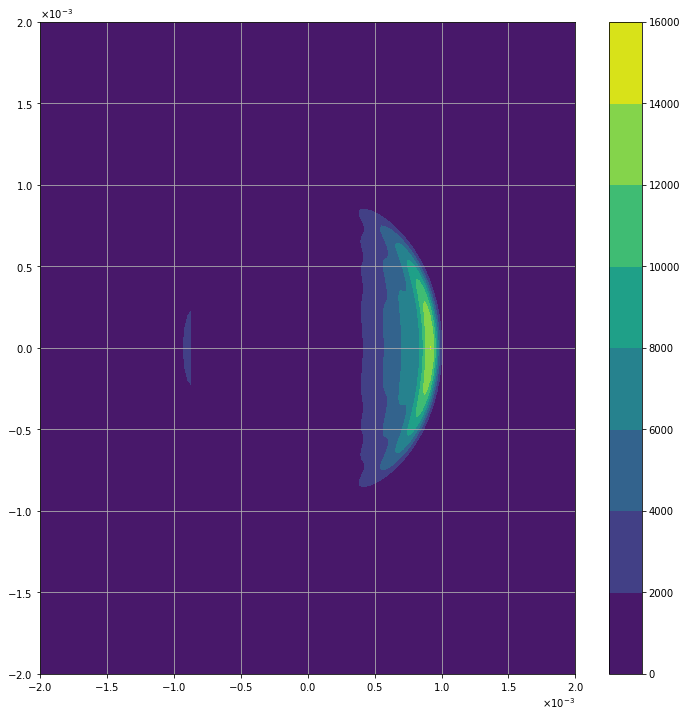

In [160]:
#get amps
f2 = pl.calculate(params,plane,sc_modes,z)

#plot
fig, ax = plt.subplots(figsize=(12, 12))
cs = plt.contourf(f2.plane.getX(), f2.plane.getY(), abs(f2.getAmp() ** 2))

ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)

cbar = fig.colorbar(cs)

plt.grid()

In [147]:
print(
(
                            (1/fac(2))*
                            (-2*10e-6/2e-3**2)**2
                        ))

12.500000000000004
